In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'LightGBM-goss特徴量ミニマム（カテゴリ変数指定）'
notebook_name = '057'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

057_submission.csv 057


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = LGBMClassifier(random_state=SEED,
                         class_weight='balanced',
                         importance_type='gain',
                         boosting_type='goss',
                         n_jobs=-1,
                         n_estimators=300,
                         learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['B', 'O', 'S', 'inningNo', 'numRunners', 'totalPitchingCount']


In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train,
            y_train.values,
            estimator__sample_weight=sample_weight,
            estimator__categorical_feature=categorical_features)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 1)**********
[[1746  890  488  815  592  315   20  200]
 [ 495 1755  307  514  331  187   18  139]
 [ 253  277  828  472  328  135   11   89]
 [ 139  159  107 1068  133   62    3   38]
 [   4    5    2    5  514    6    0    4]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[281 278 167 223 177  79   5  57]
 [163 289 113 171 100  53   4  43]
 [ 93  95 104 147  96  37   0  27]
 [ 63  59  68 135  56  30   3  13]
 [ 28  21  24  32  22   5   1   2]
 [ 11   2   0  12   5   4   1   2]
 [  2   0   0   1   0   0   0   0]
 [  2   6   6   7   3   0   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 2)**********
[[1737  880  506  806  618  317   21  181]
 [ 554 1684  315  487  352  216   14  124]
 [ 280  289  852  444  312  134    7   75]
 [ 146  156  117 1041  138   64    7   40]
 [  10    4    1    7  511    7    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 2)**********
[[292 290 170 211 163  77  10  54]
 [195 303  99 155 110  40   4  30]
 [ 90 109  88 164  82  33   3  30]
 [ 65  78  62 138  58  17   2   7]
 [ 22  21  28  36  18   4   0   6]
 [  5   8   6  11   4   3   0   0]
 [  0   2   0   0   0   0   0   0]
 [  8   3   5   4   3   1   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 3)**********
[[1762  904  486  809  586  300   18  201]
 [ 521 1667  316  550  361  176   19  136]
 [ 276  295  792  485  326  126   11   83]
 [ 140  159   99 1081  131   60    5   33]
 [   7    4    1    5  513    7    1    2]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 3)**********
[[314 294 135 210 160  85  10  59]
 [219 287  81 158  87  59   9  36]
 [104  90 100 170  76  31   1  26]
 [ 90  76  52 124  52  22   0  12]
 [ 24  24  16  37  24   4   0   6]
 [  9   8   5   9   4   1   0   1]
 [  1   0   0   0   0   1   0   0]
 [  3   4   3   7   3   2   0   2]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 4)**********
[[1735  901  537  780  605  299   16  194]
 [ 526 1697  308  521  381  184   16  112]
 [ 258  285  844  460  331  123    5   88]
 [ 145  165  107 1063  125   69    3   32]
 [   7    5    2    5  516    2    0    3]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 4)**********
[[285 292 153 239 170  81   2  44]
 [170 316 102 164  93  44   5  43]
 [ 92 104 101 149 106  31   3  12]
 [ 67  69  84 108  70  18   0  11]
 [ 20  23  25  39  14   9   2   3]
 [  6   8   4  11   6   3   0   0]
 [  1   1   0   0   0   0   0   0]
 [  6   7   6   1   3   0   0   1]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 5)**********
[[1758  886  495  770  613  313   21  211]
 [ 512 1690  309  532  359  199   19  125]
 [ 273  301  821  437  322  136    8   96]
 [ 141  164   98 1058  138   68    4   38]
 [   7    7    1    3  513    7    1    1]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 5)**********
[[293 308 136 223 161  86   1  58]
 [186 312  73 157 110  61   2  36]
 [ 94  90  94 161  91  39   1  28]
 [ 62  78  69 127  56  19   4  12]
 [ 19  22  17  46  18   6   0   7]
 [  5   7   4  10   9   2   0   1]
 [  0   1   0   1   0   0   0   0]
 [  4   5   4   4   5   0   0   2]]

Wall time: 41.7 s


In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.386916,0.144763
std,0.004588,0.002939
min,0.383333,0.140489
25%,0.384136,0.143147
50%,0.385013,0.146035
75%,0.387454,0.146246
max,0.394644,0.147900


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.122064,0.120800,0.247773,0.107888,0.321082,0.017454,0.051085,0.011855,27446,1
1,0.160592,0.090556,0.467222,0.177977,0.053640,0.007177,0.035031,0.007806,113,1
2,0.176061,0.353768,0.302343,0.080689,0.022847,0.005234,0.054528,0.004530,4479,1
3,0.191316,0.297402,0.311069,0.148084,0.032117,0.006385,0.007367,0.006261,29080,1
4,0.226180,0.159305,0.261568,0.236681,0.073715,0.014425,0.017735,0.010392,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.123263,0.275101,0.071574,0.452896,0.040707,0.012498,0.011942,0.012019,24272,5
33804,0.061434,0.067927,0.077731,0.710487,0.051528,0.011018,0.009597,0.010277,29106,5
33805,0.049533,0.055076,0.079922,0.741943,0.045841,0.010294,0.008430,0.008962,20679,5
33806,0.239627,0.085703,0.080305,0.511428,0.048696,0.012517,0.010839,0.010885,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.887438,1.180175,1.015510,1.170042,0.532415,0.081975,0.056504,0.075940
1,1,1.351841,1.798477,0.694476,0.796182,0.190963,0.090576,0.039688,0.037797
2,2,0.470101,0.410973,0.776333,1.651134,1.400591,0.141859,0.052002,0.097006
3,3,1.306835,1.386439,0.276751,1.559662,0.308087,0.058157,0.054402,0.049666
4,4,1.321948,1.850533,0.318984,0.516419,0.912441,0.026821,0.024670,0.028184
...,...,...,...,...,...,...,...,...,...
33803,33803,2.181986,0.535442,0.595539,0.752822,0.767188,0.063608,0.040131,0.063283
33804,33804,1.502973,1.028067,0.596834,1.394534,0.340278,0.045765,0.043794,0.047755
33805,33805,1.895367,1.049832,0.330424,1.243951,0.292717,0.059937,0.071413,0.056360
33806,33806,0.506706,0.514703,0.492980,1.254244,1.941521,0.138968,0.069593,0.081285


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,3
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,4


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.223734
1    0.294989
2    0.038600
3    0.360536
4    0.059365
5    0.012956
6    0.001331
7    0.008489
Name: y, dtype: float64

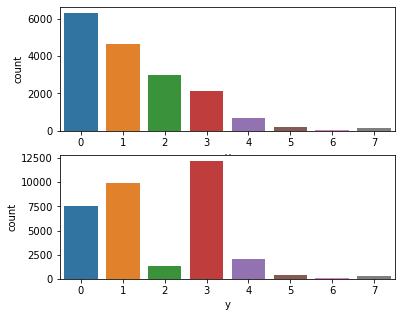

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.38691592916999334, 0.14476341584450925)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"057_submission.csv","Stratified-Kfold(K=5)","0.386916","0.144763","","LightGBM-goss特徴量ミニマム（カテゴリ変数指定）"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.67 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 13.5 ms


In [21]:
imp_df

,feature,importance,fold
0,B,63111.007703,1
1,O,69114.797311,1
2,S,63274.633540,1
3,inningNo,126732.101595,1
4,numRunners,34940.294902,1
...,...,...,...
13,isPitcherHandLeft,14736.193044,5
14,isBatterPitcher,5100.695423,5
15,isBottom,15330.009366,5
16,batterTeam,8819.806766,5


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
